In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import statsmodels.api as sm                                                                                    # p value check
from statsmodels.stats.outliers_influence import variance_inflation_factor                                      # feature importance and VIF
import joblib                                                                                                   # pickling

In [68]:
# === Load Dataset ===
def load_dataset(path):
    return pd.read_csv(path)

In [70]:
# === Feature Engineering ===
def feature_engineering(df):
    df['Order_Pressure'] = df['Ordered_Qty'] / df['Committed_Lead_Days']
    df['Vendor_Risk'] = (1 - df['Reliability_score'] / 100) * df['Quality_Rejection_Rate (%)']
    df['Transit_Risk'] = df['Avg_Transit_Days'] * df['Weather_Disruption_Index'] * df['Route Risk Score']
    df['Demand_vs_Reliability'] = df['Ordered_Qty'] / (df['Reliability_score'] + 1)
    df['Stress_Score'] = df['Transit_Risk'] * df['Order_Pressure']

    df['High_Risk_Vendor'] = (df['Vendor_Risk'] > 1.5).astype(int)
    df['High_Order_Pressure'] = (df['Order_Pressure'] > 20).astype(int)
    df['High_Transit_Risk'] = (df['Transit_Risk'] > 25).astype(int)
    df['High_Demand_vs_Reliability'] = (df['Demand_vs_Reliability'] > 8).astype(int)
    df['High_Stress_Score'] = (df['Stress_Score'] > 400).astype(int)

    df['Low_Order_Pressure'] = (df['Order_Pressure'] < 6.2).astype(int)
    df['Low_Stress_Score'] = (df['Stress_Score'] < 40).astype(int)
    df['Low_Demand_vs_Reliability'] = (df['Demand_vs_Reliability'] < 3).astype(int)
    df['Low_Vendor_Risk'] = (df['Vendor_Risk'] < 0.5).astype(int)

    df['Price_per_Unit_vs_Order'] = df['Price_per_Unit'] / (df['Ordered_Qty'] + 1)
    df['Low_Price_per_Unit_vs_Order'] = (df['Price_per_Unit_vs_Order'] < 0.05).astype(int)

    return df

In [72]:
# === Drop Columns ===
def drop_unnecessary_columns(df):
    drop_cols = [
            'Order_ID',                  #not required
            'Actual_Delivery_Date',      #not using
            'Delivered_Qty',             #cannot be given
            'Actual_Lead_Days',          #cannot be give
            'Shortfall',                 #data leakage
            'Shortfall_flag',            # Target — should be saved separately if needed
            'Delay_Indicator',           #not required for shortfall
            'vendor_name',               #not required
            'Destination',               #not required
            'Order_Date',                #not required
            'Contractual_Delivery_Date', #not required
            'vendor_id',                 # as two vendor ids columns are present
            'Transit_Risk',              # High VIF, derived
            'Vendor_Risk',               # High VIF, derived
            'Weather_Disruption_Index',  # Already in use inside feature
            'Route Risk Score',          # Already in use inside feature
            'Ordered_Qty',               # Already in use inside feature
            'Avg_Transit_Days',          # Already in use inside feature
            'Demand_vs_Reliability',     # Already in use inside feature (High VIF)
            'Reliability_score',         # Already in use inside feature (High VIF)
            'Quality_Rejection_Rate (%)',# Already in use inside feature (High VIF)
            'Committed_Lead_Days',       # Already in use inside feature (High VIF)
            'avg_lead_days',             # dont need
            'Supplier_Dependency_Index'  # didnt use yet
    ]
    return df.drop(columns=drop_cols, errors='ignore')

In [74]:
def encode_features(df):
    # Convert high-cardinality categorical variables to numeric codes
    id_cols = ['Component_ID', 'Vendor_ID', 'Route_ID', 'Source']
    for col in id_cols:
        df[col] = df[col].astype('category').cat.codes

    # Ordinal Encoding for Peak_Congestion_Indicator
    ordinal_map = {'Low': 0, 'Medium': 1, 'High': 2}
    df['Peak_Congestion_Indicator'] = df['Peak_Congestion_Indicator'].map(ordinal_map)

    # One-Hot Encoding for low-cardinality categorical variables
    cat_cols = ['Mode', 'Backup Route Availability']
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

    return df

# # # === Encode Categorical Columns ===
# def encode_features(df):
#     # Frequency Encoding for high-cardinality categorical variables
#     freq_encode_cols = ['Component_ID', 'Vendor_ID', 'Route_ID', 'Source']
#     for col in freq_encode_cols:
#         freq_map = df[col].value_counts().to_dict()
#         df[col] = df[col].map(freq_map)

#     # Ordinal Encoding
#     ordinal_map = {'Low': 0, 'Medium': 1, 'High': 2}
#     df['Peak_Congestion_Indicator'] = df['Peak_Congestion_Indicator'].map(ordinal_map)

#     # One-Hot Encoding for low-cardinality categorical variables
#     cat_cols = ['Mode', 'Backup Route Availability']
#     return pd.get_dummies(df, columns=cat_cols, drop_first=True)
#--------------------------------------------------------------------------------------------------------------------------------------------------------
# #Target encoding
# # === Encode Categorical Columns ===
# def encode_features(df, target):
#     # Ensure target column exists in df
#     df['_target_temp_'] = target.values

#     # Target Encoding for high-cardinality categorical variables
#     target_encode_cols = ['Component_ID', 'Vendor_ID', 'Route_ID', 'Source']
#     for col in target_encode_cols:
#         target_map = df.groupby(col)['_target_temp_'].mean().to_dict()
#         df[col] = df[col].map(target_map)

#     df.drop(columns=['_target_temp_'], inplace=True)

#     # Ordinal Encoding
#     ordinal_map = {'Low': 0, 'Medium': 1, 'High': 2}
#     df['Peak_Congestion_Indicator'] = df['Peak_Congestion_Indicator'].map(ordinal_map)

#     # One-Hot Encoding
#     cat_cols = ['Mode', 'Backup Route Availability']
#     return pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [76]:
# === Split and Scale Data ===
def split_and_scale_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

In [78]:
# === Apply SMOTE ===
def apply_smote(X_train_scaled, y_train):
    sm = SMOTE(random_state=42)
    return sm.fit_resample(X_train_scaled, y_train)

In [80]:
# === Dimensionality Reduction ===
def apply_pca(X_train, X_test, n_components=10):
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca

def apply_fa(X_train, X_test, n_components=10):
    fa = FactorAnalysis(n_components=n_components, random_state=42)
    X_train_fa = fa.fit_transform(X_train)
    X_test_fa = fa.transform(X_test)
    return X_train_fa, X_test_fa

In [82]:
# === Plot ROC Curve ===
def plot_roc_curve(y_test, y_probs, model_name):
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    auc = roc_auc_score(y_test, y_probs)
    plt.figure()
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [84]:
#-------------------------------------------------------------------------------------------------------------------------------------------------
def train_and_evaluate_model(model, model_name, X_train_res, y_train_res, X_test_scaled, y_test):
    model.fit(X_train_res, y_train_res)

    # Predict directly (no threshold tuning)
    y_pred = model.predict(X_test_scaled)

    # Probabilities for ROC
    y_probs = model.predict_proba(X_test_scaled)[:, 1]

    # Evaluation
    print(f"\n===== {model_name} =====")

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    plot_roc_curve(y_test, y_probs, model_name)

In [86]:
import statsmodels.api as sm

# === P-Value Checker ===
def run_p_value_check(X, y):
    X = X.astype(float)
    X_const = sm.add_constant(X)
    logit_model = sm.Logit(y, X_const)
    result = logit_model.fit()
    print(result.summary())

In [88]:
def get_feature_importance(model, X, top_n=20):
    """
    Plots and prints top N feature importances for tree-based models.
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Create importance DataFrame
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    # Print top N as table
    print(f"\n📊 Top {top_n} Feature Importances:")
    print(importance_df.head(top_n).to_string(index=False))

    # Plot top N
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(top_n))
    plt.title("Top Feature Importances")
    plt.tight_layout()
    plt.show()

    return importance_df

In [90]:
def calculate_vif(X):
    """
    Returns a DataFrame with Variance Inflation Factors for all features.
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    import pandas as pd

    X = X.copy()
    X = X.astype(float)  # ensure numerical
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return vif_data.sort_values(by="VIF", ascending=False)

In [92]:
#FOR CHANDAN 
def save_final_balanced_dataset(X_train_res, y_train_res, reference_columns, scaler, model, filename='final_balanced_with_predictions.csv'):
    # Convert resampled X to DataFrame
    X_res_df = pd.DataFrame(X_train_res, columns=reference_columns)
    # Predict on balanced data
    probs = model.predict_proba(X_train_res)[:, 1]
    preds = (probs >= 0.5).astype(int)
    # Add predictions and target
    X_res_df['Predicted_Shortfall_Flag'] = preds
    X_res_df['True_Shortfall_Flag'] = y_train_res.reset_index(drop=True)
    # Save to CSV
    X_res_df.to_csv(filename, index=False)
    print(f"✅ Final balanced dataset with predictions saved to: {filename}")

In [94]:
#FOR CHANDAN
def save_test_predictions(X_test, y_test, reference_columns, model, filename='test_predictions.csv'):
    import pandas as pd

    # Predict probabilities and labels
    probs = model.predict_proba(X_test)[:, 1]
    preds = (probs >= 0.5).astype(int)

    # Convert X_test_scaled to DataFrame
    X_test_df = pd.DataFrame(X_test, columns=reference_columns)

    # Add prediction columns
    X_test_df['Predicted_Shortfall_Flag'] = preds
    X_test_df['Probability_Shortfall'] = probs

    # Save to CSV
    X_test_df.to_csv(filename, index=False)
    print(f"✅ Test predictions saved to: {filename}")

Optimization terminated successfully.
         Current function value: 0.080887
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:         Shortfall_flag   No. Observations:                 8374
Model:                          Logit   Df Residuals:                     8349
Method:                           MLE   Df Model:                           24
Date:                Fri, 27 Jun 2025   Pseudo R-squ.:                  0.5381
Time:                        10:21:40   Log-Likelihood:                -677.35
converged:                       True   LL-Null:                       -1466.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             4.6503      0.609      7.641      0

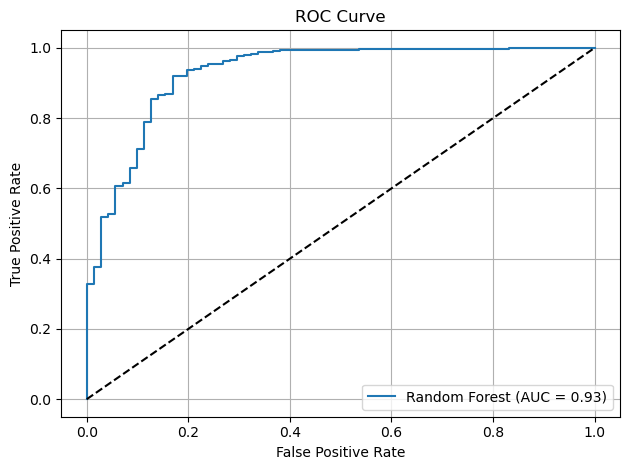


📊 Top 20 Feature Importances:
                      Feature  Importance
      Price_per_Unit_vs_Order    0.209757
               Order_Pressure    0.199076
           Low_Order_Pressure    0.113605
    Low_Demand_vs_Reliability    0.085786
                 Stress_Score    0.049001
             Low_Stress_Score    0.040827
               Price_per_Unit    0.033819
                 Component_ID    0.030819
  Low_Price_per_Unit_vs_Order    0.030418
              Low_Vendor_Risk    0.022702
          past_incident_count    0.022156
   High_Demand_vs_Reliability    0.022030
          High_Order_Pressure    0.017688
         collaboration_tenure    0.016773
                    Vendor_ID    0.016597
                     Route_ID    0.015931
Backup Route Availability_Yes    0.015788
    Peak_Congestion_Indicator    0.013145
                       Source    0.013039
                   Mode_Train    0.010161


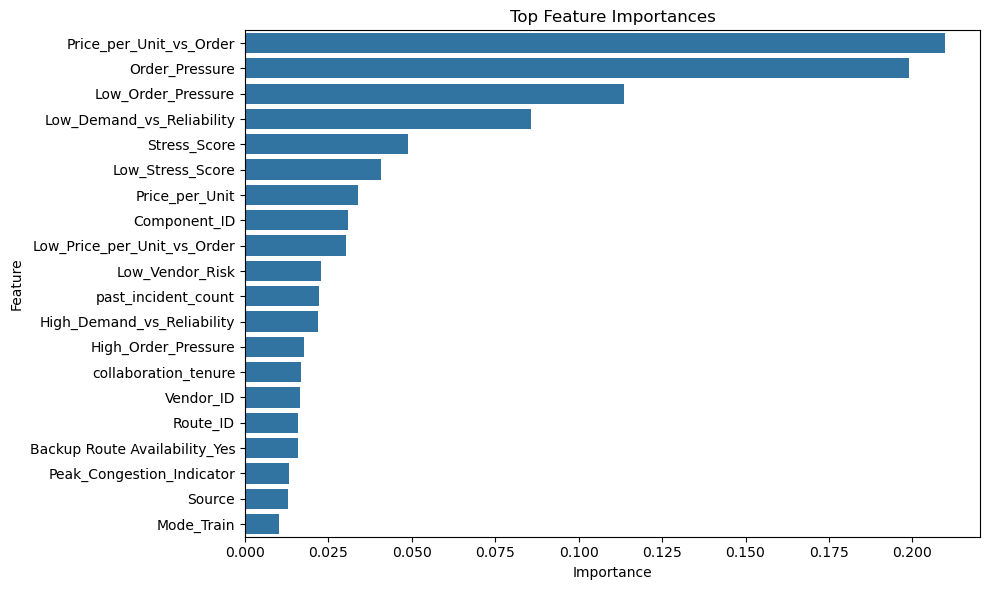


===== Without PCA/FA Random Forest =====
Accuracy: 0.9665671641791045
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.68      0.63        71
           1       0.99      0.98      0.98      1604

    accuracy                           0.97      1675
   macro avg       0.79      0.83      0.81      1675
weighted avg       0.97      0.97      0.97      1675

Confusion Matrix:
 [[  48   23]
 [  33 1571]]


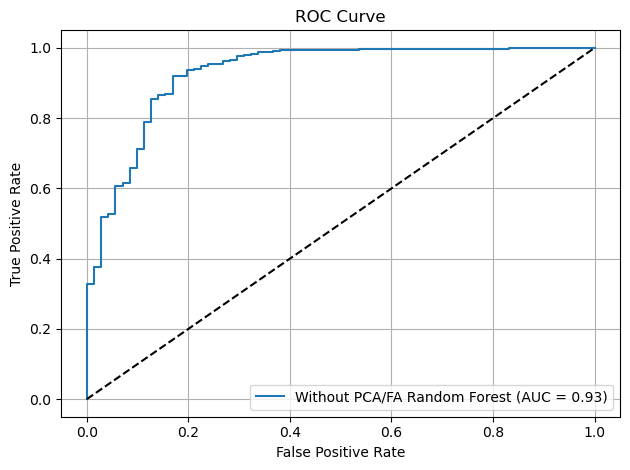


===== With PCA/FA Random Forest =====
Accuracy: 0.9486567164179105
Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.66      0.52        71
           1       0.98      0.96      0.97      1604

    accuracy                           0.95      1675
   macro avg       0.71      0.81      0.75      1675
weighted avg       0.96      0.95      0.95      1675

Confusion Matrix:
 [[  47   24]
 [  62 1542]]


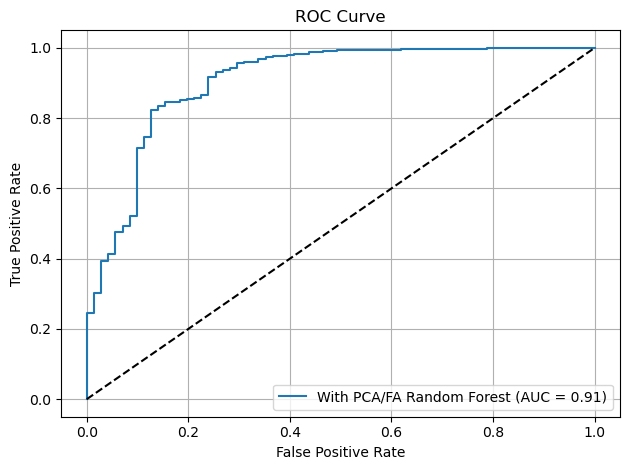

In [96]:
# === Main Pipeline ===
def main():
    df = load_dataset("full_merged_data_v1.csv")
    df = feature_engineering(df)
    target = df['Shortfall_flag'].copy()
    df = drop_unnecessary_columns(df)
    df_encoded = encode_features(df)
    # df_encoded = encode_features(df, target) # for target encoding

    X = df_encoded.copy()
    y = target
    run_p_value_check(X, y)

    print("\n--- VIF Scores ---")
    print(calculate_vif(X))
    
    X_train_scaled, X_test_scaled, y_train, y_test, scaler = split_and_scale_data(X, y)
    X_train_res, y_train_res = apply_smote(X_train_scaled, y_train)

    rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
    train_and_evaluate_model(rf_model, "Random Forest", X_train_res, y_train_res, X_test_scaled, y_test)
    get_feature_importance(rf_model, pd.DataFrame(X_train_res, columns=X.columns))

    # # === Apply PCA or FA ===
    X_train_reduced, X_test_reduced = apply_pca(X_train_res, X_test_scaled, n_components=15)
    # X_train_reduced, X_test_reduced = apply_fa(X_train_res, X_test_scaled, n_components=15)

    # Compare baseline model vs PCA model
    #Without PCA/FA
    train_and_evaluate_model(RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42), "Without PCA/FA Random Forest", X_train_res, y_train_res, X_test_scaled, y_test)
    # train_and_evaluate_model(LogisticRegression(penalty='l1',solver='liblinear',C=1.0,random_state=42), "Without PCA/FA Logistic Regression", X_train_res, y_train_res, X_test_scaled, y_test)
    # train_and_evaluate_model(XGBClassifier(n_estimators=100,learning_rate=0.1,max_depth=6,reg_alpha=0.5), "Without PCA/FA XGBoost", X_train_res, y_train_res, X_test_scaled, y_test)
    # train_and_evaluate_model(SVC(probability=True), "Without PCA/FA SVM", X_train_res, y_train_res, X_test_scaled, y_test)

    #With PCA/FA
    train_and_evaluate_model(RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42), "With PCA/FA Random Forest", X_train_reduced, y_train_res, X_test_reduced, y_test)
    # train_and_evaluate_model(LogisticRegression(penalty='l1',solver='liblinear',C=1.0,random_state=42), "With PCA/FA Logistic Regression", X_train_reduced, y_train_res, X_test_reduced, y_test)
    # train_and_evaluate_model(XGBClassifier(n_estimators=100,learning_rate=0.1,max_depth=6,reg_alpha=0.5), "With PCA/FA XGBoost", X_train_reduced, y_train_res, X_test_reduced, y_test)
    # train_and_evaluate_model(SVC(probability=True), "With PCA/FA SVM", X_train_reduced, y_train_res, X_test_reduced, y_test)

if __name__ == '__main__':
    main()

In [21]:
# Pickling

# import joblib
# === To Save Model, Scaler, and Columns using joblib ===
# model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
# model.fit(X_train_res,y_train_res)
# joblib.dump(model, "model.pkl")
# joblib.dump(scaler, "scaler.pkl")
# joblib.dump(X.columns.tolist(), "columns.pkl")
# print("✅ Model, scaler, and training columns saved using joblib.")

# #for loading model later
# # model = joblib.load("model.pkl")
# # scaler = joblib.load("scaler.pkl")
# # reference_columns = joblib.load("columns.pkl")

# ✅ Save final dataset before scaling
# df_encoded['Shortfall_flag'] = target
# df_encoded.to_csv("finalDataset.csv", index=False)
# print("✅ Final dataset saved as 'finalDataset.csv'")

# Save balanced data with predictions
# save_final_balanced_dataset(X_train_res, y_train_res, X.columns.tolist(), scaler, model)

# model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
# model.fit(X_train_res,y_train_res)
# joblib.dump(model, "model.pkl")
# joblib.dump(scaler, "scaler.pkl")
# joblib.dump(X.columns.tolist(), "columns.pkl")
# print("✅ Model, scaler, and training columns saved using joblib.")

# model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
# model.fit(X_train_res,y_train_res)
# save_test_predictions(X_test, y_test, X.columns.tolist(), model)
